# Interommatidial angle of the *Megaphragma* compound eye
- Amount in which they sample from overlapping receptive fields 
- Compare interommatidial angle with the spacing of lens centers

In [19]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import combinations
#import statsmodels.api as sm
from sklearn.decomposition import PCA

from cx_analysis.catmaid_queries import skels_in_annot, skel_compact_detail, node_coords
from cx_analysis.vis.hex_lattice import om_to_hex

Data: 
Rhabdom centerlines drawn on CATMAID for each ommatidia in specimen 1. (nc)

**right eye** 2019-1-29 
- annotation: rhabdom_centerline
- name: omXY_axon_to_lens
- n = 29
**left eye** 2021-6-17
- annotation: rhabdom_centerlineLEFT
- name: omXYL_axon_to_lens
- n = 29

In [2]:
# catmaid access 
cm_token = os.environ['CM_TOKEN']
cm_url = os.environ['CM_URL']

cfg = {'cm_token': os.environ['CM_TOKEN'], 'cm_url': os.environ['CM_URL'], 
      'p_id': 1}

centerline_skels = skels_in_annot('rhabdom_centerline', cfg)
assert(len(centerline_skels[0]) == 29)  # 29 ommatidia

In [12]:
def sorted_node_coordinates(node_data):
    """
    Return an ordered list of skeleton coordinates using the ref to each node's 
    parent. This will not work for branched skeletons (where a node can have
    more than one child)
    :params node_data: N x 8 List from skel_compact_detail where N = number of nodes
    :return coords: 
    """
    node_data = pd.DataFrame(node_data, columns=['id', 'parent_id', 't', 'x', 'y', 'z', 'u', 'v'])
    node_data['id'] = node_data['id'].astype(float)
    #print(node_data)
    parent_ids = node_data['parent_id']
    #print(parent_ids)
    coords = []
    root_node = node_data.loc[node_data['parent_id'].isna()]
    current = root_node
    
    coords.append([*current['x'].values, *current['y'].values, *current['z'].values])

    while float(current['id'].values[0]) in parent_ids.tolist():
        current_id = current['id']
        next_ind = node_data['parent_id'].isin(current_id)
        assert(next_ind.sum() == 1) # make sure only one is next
        current = node_data.loc[next_ind]
        
        coords.append([*current['x'].values, *current['y'].values, *current['z'].values])
    #print(coords)
    assert(len(coords) == len(node_data))
    return np.array(coords)
        
om_points = dict()  # e.g. 'A2': [[x0, y0, z0], ... ]

for skel_id, name in zip(*centerline_skels):
    om = name[2:4]
    these_nodes = skel_compact_detail(skel_id, cfg)  # list of node IDs ii
    #print(these_nodes)
    om_points[om] = sorted_node_coordinates(these_nodes)
    
center_points = np.array([p[-1] for om, p in om_points.items()])

9
8
7
6
19
18
17
16
15
14
13
12
11
10
9
8
23
22
21
20
19
18
17
16
15
14
13
12
11
21
20
19
18
17
16
15
14
13
12
11
10
9
12
11
10
9
8
7
11
10
9
8
7
6
9
8
7
6
5
4
10
9
8
7
6
7
6
5
4
3
8
7
6
5
4
8
7
6
5
4
3
11
10
9
8
7
6
8
7
6
5
4
3
8
7
6
5
4
10
9
8
7
6
5
4
13
12
11
10
9
8
7
6
10
9
8
7
6
5
9
8
7
6
5
10
9
8
7
6
5
8
7
6
5
4
3
11
10
9
8
7
6
5
15
14
13
12
11
10
9
8
7
11
10
9
8
7
12
11
10
9
8
7
13
12
11
10
9
8
7
13
12
11
10
9
8
7
6
5
11
10
9
8
7
6
9
8
7
6
29
28
27
26
25
24
23
22
21
20
19
18
17
16
4952.43912833625


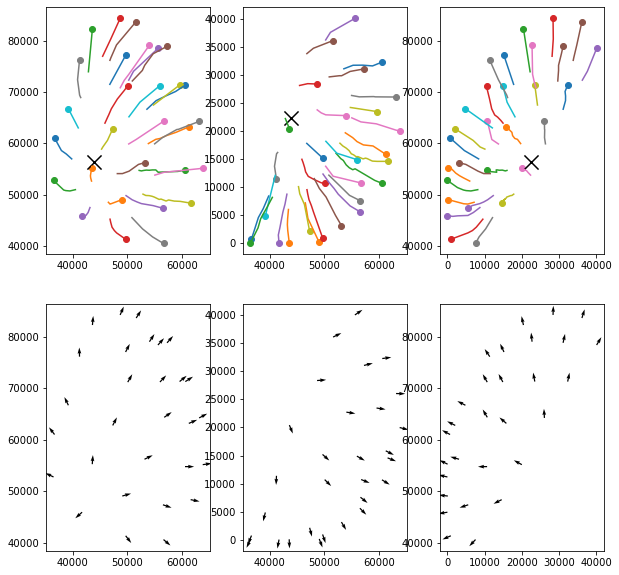

In [33]:
fig, ax = plt.subplots(2, 3, figsize=[10, 10])
axes = ax.flatten()

# Average center
mean_center = np.mean(center_points, axis=0)
pcs = dict()
norms = dict()

for om, p in om_points.items():
    # Make sure the first coordinate is the most apical
    assert(np.linalg.norm(mean_center - p[0]) > np.linalg.norm(mean_center - p[1]))
    
    norm = np.linalg.norm(p[-1] - p[0])
    norms[om] = norm
    
    while np.linalg.norm(p[-1] - p[0]) > 10000:
        
        p = np.delete(p, -1, 0)
    
    # Show data
    axes[0].plot(p[:, 0], p[:, 1])
    axes[0].scatter(p[0, 0], p[0, 1])
    
    axes[1].plot(p[:, 0], p[:, 2])
    axes[1].scatter(p[0, 0], p[0, 2])
    
    axes[2].plot(p[:, 2], p[:, 1])
    axes[2].scatter(p[0, 2], p[0, 1])
    
    # PCA to obtain unit vectors
    pca = PCA(n_components=1)
    pca.fit(p)
    c = pca.components_[0]
    # Invert sign of PC so the transformed unit is larger near lens 
    if np.dot(c, p[-1]) > np.dot(c, p[0]):
        c = c * -1
    pcs[om] = c
    norm = np.linalg.norm(p[-1] - p[0])

    axes[3].quiver(p[0, 0], p[0, 1], norm*c[0], norm*c[1])
    axes[4].quiver(p[0, 0], p[0, 2], norm*c[0], norm*c[2])
    axes[5].quiver(p[0, 2], p[0, 1], norm*c[2], norm*c[1])
#     axes[3].quiver(mean_center[0], mean_center[1], norm*c[0], norm*c[1])
#     axes[4].quiver(mean_center[0], mean_center[2], norm*c[0], norm*c[2])
#     axes[5].quiver(mean_center[2], mean_center[1], norm*c[2], norm*c[1])
    
axes[0].scatter(mean_center[0], mean_center[1], s=200, marker='x', c='k')
axes[1].scatter(mean_center[0], mean_center[2], s=200, marker='x', c='k')
axes[2].scatter(mean_center[2], mean_center[1], s=200, marker='x', c='k')

n = np.array([n for o, n in norms.items()])
print(np.mean(n * 0.25))
    

In [34]:
def hex_distance(o1: str, o2: str) -> float:
    c1 = np.array(om_to_hex(o1, scale_factor=1.0))
    c2 = np.array(om_to_hex(o2, scale_factor=1.0))
    
    return np.linalg.norm(c1-c2)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

0.07699148961336133
0.883635425673127


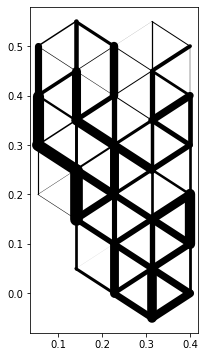

In [36]:
fig, ax = plt.subplots(1, figsize=[3, 6])

om_pairs = list(combinations(om_points.keys(), 2))
pair_angle = dict()

for o1, o2 in om_pairs:
    if hex_distance(o1, o2) > 1.1:
        continue
    else:
        x1, y1 = om_to_hex(o1)
        x2, y2 = om_to_hex(o2)
        pair_angle[o1+o2] = angle_between(pcs[o1], pcs[o2])
        w = (pair_angle[o1+o2] - 0.5) * 30
        ax.plot([x1, x2], [y1, y2], linewidth=w, color='k', zorder=0, solid_capstyle='round')
#         ax.annotate(f"{d['ret_dist']: .0f}", ((x1 + x2)/2.0, (y1 + y2)/2.0), 
#                     fontsize=3.5, color='grey', horizontalalignment='center', verticalalignment='center')

print(min([v for k, v in pair_angle.items()]))
print(max([v for k, v in pair_angle.items()]))
        

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=[10, 10])
axes = ax.flatten()
fits = []

for om, coords in om_points.items():
    axes[0].scatter(x=coords[:, 0], y=coords[:, 1])
    
    axes[1].scatter(x=coords[:, 0], y=coords[:, 2])
    axes[2].scatter(x=coords[:, 2], y=coords[:, 1])
    
    xy = coords[:, 0:2]
    z = coords[:, 2]
    
    model = sm.OLS(z, xy)
    results = model.fit()
    params = results.params
    print(params)
#     s1 = range(0, 5)
#     s2 = range(5, 9)
#     p1 = c[0]
#     p2 = c[-1]
#     axes[0].plot([p1[0], p2[0]], [p1[1], p2[1]])
#     axes[1].plot([p1[0], p2[0]], [p1[2], p2[2]])
#     axes[2].plot([p1[2], p2[2]], [p1[1], p2[1]])
axes[0].scatter(x=all_points[:, 0].mean(), y=all_points[:, 1].mean(), s=500)
axes[0].set_title('xy')
axes[1].set_title('xz')
axes[2].set_title('yz')

In [ ]:
np.argmin(all_points, axis=0)